In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
plt.rcParams['figure.figsize'] = (16, 4)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

import utils

In [2]:
farm1 = pd.read_csv('data/wf1_data.csv')
farm2 = pd.read_csv('data/wf2_data.csv')
farm3 = pd.read_csv('data/wf3_data.csv')

farm1['date'] = pd.to_datetime(farm1['date'], format = '%Y%m%d%H')
farm2['date'] = pd.to_datetime(farm2['date'], format = '%Y%m%d%H')
farm3['date'] = pd.to_datetime(farm3['date'], format = '%Y%m%d%H')

farm1 = farm1.set_index('date').sort_index()
farm2 = farm2.set_index('date').sort_index()
farm3 = farm3.set_index('date').sort_index()
farm3.head()

,wp,ws
date,,
2009-07-01 01:00:00,0.105,3.81
2009-07-01 02:00:00,0.033,3.68
2009-07-01 03:00:00,0.022,3.66
2009-07-01 04:00:00,0.039,3.70
2009-07-01 06:00:00,0.105,3.66


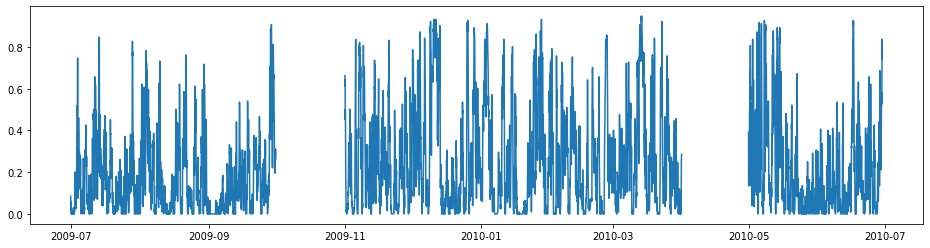

In [61]:
#plot
plt.plot(farm1.wp, label='farm1 wp');
# plt.plot(farm1.ws, label='farm1 ws');

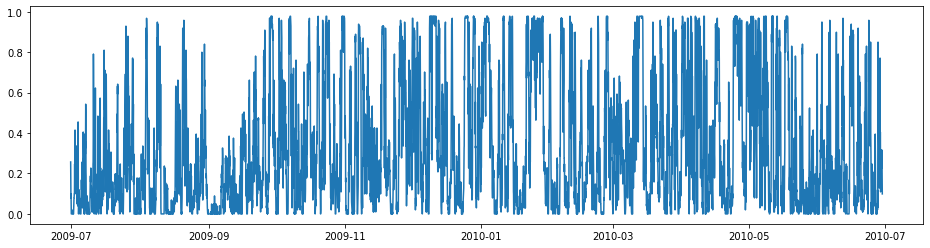

In [36]:
plt.plot(farm2.wp, label='farm2')

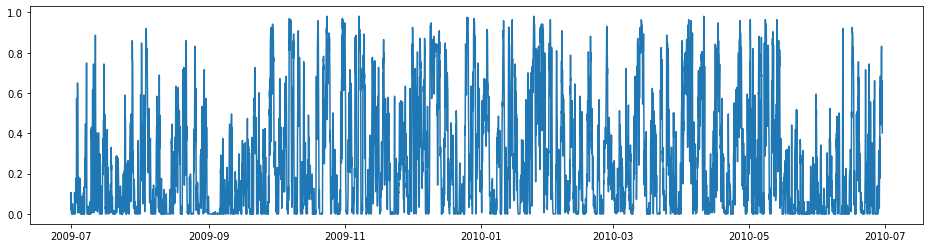

In [215]:
plt.plot(farm3.wp, label='farm3')

In [20]:
#BaseLine Model: from may2010
farm1_baseline = farm1.loc['may 2010':].dropna()#(1440, 2)
farm2_baseline = farm2.loc['may 2010':].dropna()#(1440, 2)
farm3_baseline = farm3.loc['may 2010':].dropna()#(1315, 2) - 125 missing values
farm3_baseline = farm3_baseline.resample('h').mean()
farm3_baseline['wp'] = farm3_baseline.wp.interpolate()

In [21]:
#split between train e test set

farm1_baseline_train = farm1_baseline[:-24*7].drop('ws', axis=1)
farm1_baseline_test  = farm1_baseline[-24*7:].drop('ws', axis=1)

farm2_baseline_train = farm2_baseline[:-24*7].drop('ws', axis=1)
farm2_baseline_test  = farm2_baseline[-24*7:].drop('ws', axis=1)

farm3_baseline_train = farm3_baseline[:-24*7].drop('ws', axis=1)
farm3_baseline_test  = farm3_baseline[-24*7:].drop('ws', axis=1)

farm1_baseline_train.head()

,wp
date,
2010-05-01 00:00:00,0.391
2010-05-01 01:00:00,0.135
2010-05-01 02:00:00,0.170
2010-05-01 03:00:00,0.236
2010-05-01 04:00:00,0.391


In [6]:
sarimax_pipeline_f1 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2
                          )
    )
])

sarimax_pipeline_f1.fit(farm1_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=1093.436, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=1142.308, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=1103.331, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=1102.331, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=1140.308, Time=0.11 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=1103.957, Time=0.73 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=1104.853, Time=0.50 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=1095.404, Time=2.56 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=1095.400, Time=3.86 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=1104.410, Time=0.38 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=1099.750, Time=1.45 sec
 ARIMA(1,1,1)(2,0,0)[2] intercept   : AIC=1100.640, Time=1.03 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=1097.292, Time=3.02 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=1091.560, Time=0.94 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=2, suppress_warnings=True, trace=True))])

In [7]:
pred_f1 = sarimax_pipeline_f1.predict(24*7)
mean_absolute_error(pred_f1,farm1_baseline_test)


0.1684875822326576

In [10]:
pred_f1_1day.shape

(192,)

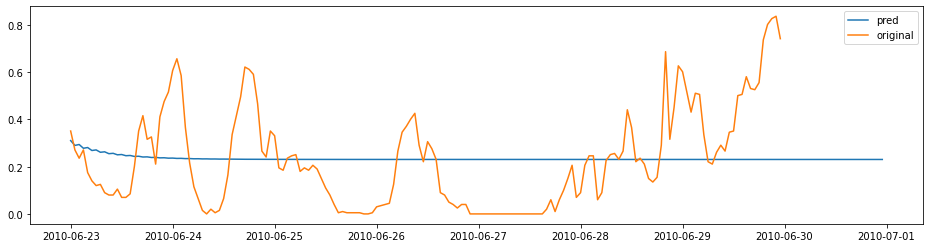

In [11]:
pred_f1_1day = sarimax_pipeline_f1.predict(24*7+24)

plt.plot(pd.Series(pred_f1_1day, index=farm1[-(24*7+24):].index), label='pred')
plt.plot(farm1[-(24*7+24):].wp, label='original')
plt.legend();

In [12]:
sarimax_pipeline_f2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=3
                          )
    )
])

sarimax_pipeline_f2.fit(farm2_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=948.626, Time=4.06 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=1020.082, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=992.391, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=985.872, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=1018.082, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=945.584, Time=3.71 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=942.056, Time=1.67 sec
 ARIMA(2,1,2)(1,0,0)[3] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,1,2)(0,0,0)[3] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[3] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=986.277, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[3]             : AIC=inf, Time=0.56 sec

Best model:  ARIMA(2,1,2)(0,0,0)[3] intercept
Total fit time: 17.073 seconds


Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=3, suppress_warnings=True, trace=True))])

In [15]:
pred_f2 = sarimax_pipeline_f2.predict(24*7)
mean_absolute_error(pred_f2,farm2_baseline_test)

0.19722702587415902

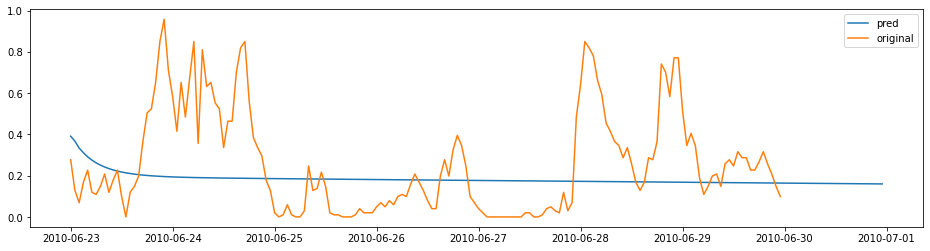

In [16]:
pred_f2_1day = sarimax_pipeline_f2.predict((24*7+24))

plt.plot(pd.Series(pred_f2_1day, index=farm2[-(24*7+24):].index), label='pred')
plt.plot(farm2[-(24*7+24):].wp, label='original')
plt.legend();

In [22]:
sarimax_pipeline_f3 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2
                          )
    )
])

sarimax_pipeline_f3.fit(farm3_baseline_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=4384.608, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=3879.884, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=4382.608, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=4062.086, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=3780.012, Time=0.54 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=4353.800, Time=0.17 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,0,0)(2,1,0)[2]             : AIC=3778.012, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[2]             : AIC=3877.884, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[2]             : AIC=inf, Time=1.17 sec
 A

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=2, suppress_warnings=True, trace=True))])

In [23]:
pred_f3 = sarimax_pipeline_f3.predict(24*7)
mean_absolute_error(pred_f3,farm3_baseline_test)

0.19731998471919368

In [24]:
pred_f3_1day = sarimax_pipeline_f3.predict((24*7+24))

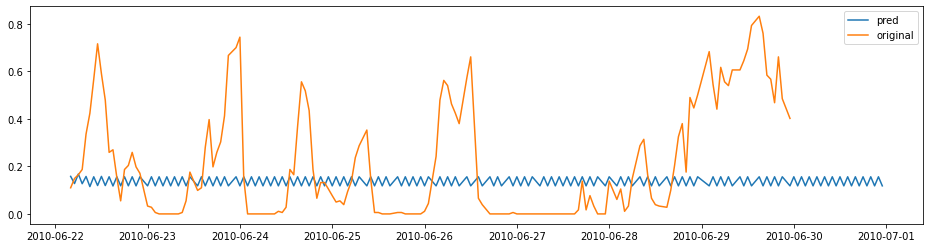

In [25]:
plt.plot(pd.Series(pred_f3_1day, index=farm3[-(24*7+24):].index), label='pred')
plt.plot(farm3[-(24*7+24):].wp, label='original')
plt.legend();

In [156]:
submition1 = pd.Series(pd.concat([pd.Series(pred_f1_1day[-24:]), pd.Series(pred_f2_1day[-24:]), pd.Series(pred_f3_1day[-24:])]),name='value')


### Adding exogenous variable in the previous models

In [176]:
#wind speed

farm1_baseline.ws.isnull().sum()#0
farm2_baseline.ws.isnull().sum()#0
farm3_baseline.ws.isnull().sum()#125

125

In [26]:
farm3_baseline['ws'] = farm3_baseline.ws.interpolate()

In [27]:
#split exogeneous between train e test set

farm1_exog_train = farm1_baseline[:-24*7].drop('wp', axis=1)
farm1_exog_test  = farm1_baseline[-24*7:].drop('wp', axis=1)

farm2_exog_train = farm2_baseline[:-24*7].drop('wp', axis=1)
farm2_exog_test  = farm2_baseline[-24*7:].drop('wp', axis=1)

farm3_exog_train = farm3_baseline[:-24*7].drop('wp', axis=1)
farm3_exog_test  = farm3_baseline[-24*7:].drop('wp', axis=1)

farm3_exog_train.head()

,ws
date,
2010-05-01 00:00:00,4.78
2010-05-01 01:00:00,4.62
2010-05-01 02:00:00,4.65
2010-05-01 03:00:00,4.66
2010-05-01 04:00:00,4.59


In [28]:
sarimax_pipeline_exog_f1 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f1.fit(farm1_baseline_train,farm1_exog_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=-2851.729, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=-2815.136, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=-2851.515, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=-2853.517, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=-2805.683, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=-2846.905, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=-2856.245, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept   : AIC=-2852.044, Time=0.24 sec
 ARIMA(0,1,1)(2,0,1)[2] intercept   : AIC=-2857.107, Time=0.30 sec
 ARIMA(0,1,1)(2,0,0)[2] intercept   : AIC=-2857.075, Time=0.29 sec
 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=-2868.032, Time=0.48 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=-2863.694, Time=0.44 sec
 ARIMA(0,1,0)(2,0,2)[2] intercept   : AIC=-2847.613, Time=0.37 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=-2862.833, Time=0.47 sec
 ARIMA(1,1,0)(2,0,2

Pipeline(steps=[('arima',
                 AutoARIMA(m=2, maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [29]:
pred_exog_f1 = sarimax_pipeline_exog_f1.predict(24*7,farm1_exog_test)
mean_absolute_error(pred_exog_f1,farm1_baseline_test)

0.17360244941144312

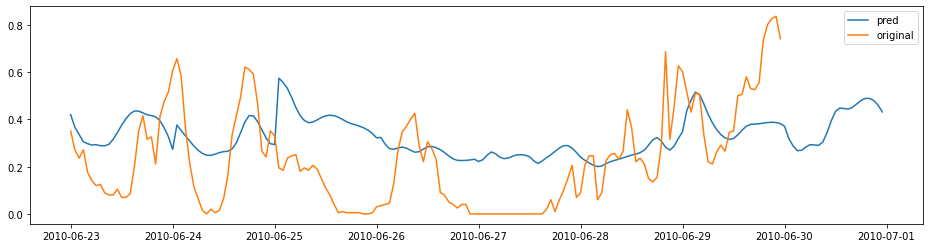

In [30]:
pred_f1_exog_1day = sarimax_pipeline_exog_f1.predict((24*7+24),pd.concat([pd.DataFrame(farm1.ws[-24:]),farm1_exog_test],axis=0))
plt.plot(pd.Series(pred_f1_exog_1day, index=farm1[-(24*7+24):].index), label='pred')
plt.plot(farm1[-(24*7+24):].wp, label='original')
plt.legend();

In [31]:
sarimax_pipeline_exog_f2 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=1, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f2.fit(farm2_baseline_train,farm2_exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1866.618, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1808.370, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1836.035, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1844.368, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1802.143, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1873.191, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1852.798, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1847.304, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1871.175, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1859.777, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1862.116, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1871.107, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1876.658, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1854.787, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [33]:
pred_exog_f2 = sarimax_pipeline_exog_f2.predict(24*7,farm2_exog_test)
mean_absolute_error(pred_exog_f2,farm2_baseline_test)

0.2853124416902756

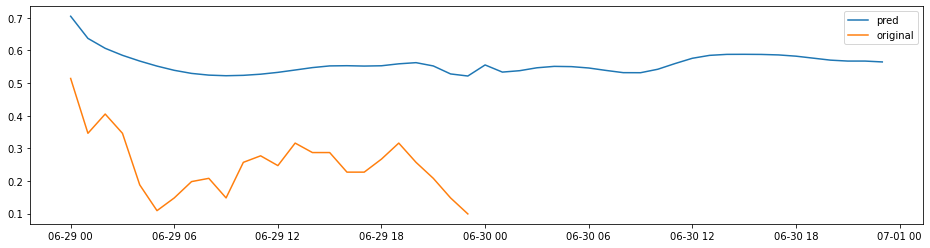

In [212]:
pred_f2_exog_1day = sarimax_pipeline_exog_f2.predict((24*7+24),pd.concat([pd.DataFrame(farm2.ws[-24:]),farm2_exog_test],axis=0))
plt.plot(pd.Series(pred_f2_exog_1day, index=farm2[-(24*7+24):].index), label='pred')
plt.plot(farm2[-(24*7+24):].wp, label='original')
plt.legend();

In [34]:
sarimax_pipeline_exog_f3 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=2, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f3.fit(farm3_baseline_train,farm3_exog_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=-2703.246, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=-2615.629, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=-2705.729, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=-2710.393, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=-2607.806, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=-2702.605, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=-2707.993, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[2] intercept   : AIC=-2720.480, Time=0.40 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=-2719.030, Time=0.42 sec
 ARIMA(0,1,0)(0,0,2)[2] intercept   : AIC=-2655.094, Time=0.32 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=-2714.656, Time=0.40 sec
 ARIMA(1,1,0)(0,0,2)[2] intercept   : AIC=-2720.914, Time=0.35 sec
 ARIMA(1,1,0)(0,0,1)[2] intercept   : AIC=-2710.413, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[2] intercept   : AIC=-2719.651, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1

Pipeline(steps=[('arima',
                 AutoARIMA(m=2, maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [36]:
pred_exog_f3 = sarimax_pipeline_exog_f3.predict(24*7,farm3_exog_test)
mean_absolute_error(pred_exog_f3,farm3_baseline_test)

0.18250447983544532

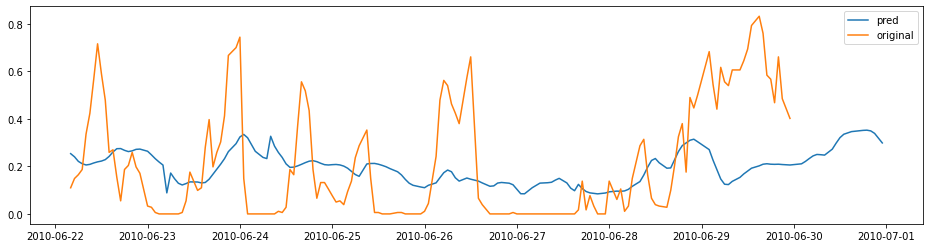

In [37]:
pred_f3_exog_1day = sarimax_pipeline_exog_f3.predict((24*7+24),pd.concat([pd.DataFrame(farm3.ws[-24:]),farm3_exog_test],axis=0))
plt.plot(pd.Series(pred_f3_exog_1day, index=farm3[-(24*7+24):].index), label='pred')
plt.plot(farm3[-(24*7+24):].wp, label='original')
plt.legend();

In [38]:
farm1_baseline.wp.corr(farm1_baseline.ws), farm2_baseline.wp.corr(farm2_baseline.ws), farm3_baseline.wp.corr(farm3_baseline.ws)

(0.6606486860258949, 0.6335877017527877, 0.6618843673503232)